# Download Dataset

https://www.kaggle.com/arunrk7/surface-crack-detection

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'kawonjeong' # username
os.environ['KAGGLE_KEY'] = '' # key

In [5]:
!kaggle datasets download -d arunrk7/surface-crack-detection --force

100%|███████████████████████████████████████▉| 233M/233M [01:44<00:00, 2.22MB/s]
100%|████████████████████████████████████████| 233M/233M [01:44<00:00, 2.33MB/s]


In [6]:
!unzip -q surface-crack-detection.zip

# Install alibi_detect

In [7]:
!pip install alibi_detect

     |████████████████████████████████| 280 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 458.4 MB 23 kB/s  eta 0:00:011     |███████████▏                    | 159.6 MB 3.2 MB/s eta 0:01:33     |██████████████████▊             | 267.7 MB 408 kB/s eta 0:07:47     |████████████████████████████    | 402.1 MB 409 kB/s eta 0:02:18
     |████████████████████████████████| 4.8 MB 470 kB/s eta 0:00:01
     |████████████████████████████████| 86 kB 4.6 MB/s  eta 0:00:01
     |████████████████████████████████| 60.3 MB 12.3 MB/s eta 0:00:01
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
     |████████████████████████████████| 4.0 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 1.2 MB/s eta 0:00:011
     |████████████████████████████████| 4.4 MB 2.1 MB/s eta 0:00:011
     |████████████████████████████████| 1.1 MB 9.3 MB/s eta 0:00:01
  Using cached tensorboard-2.6.0-py3

# Import Packages

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer #딥러닝 레이어를 만드는 모듈들
from alibi_detect.models.tensorflow.losses import elbo
from alibi_detect.od import OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob

# Load Normal Images

- Negative: normal images
- Positive: crack images

In [3]:
#정상(Negative) 이미지의 파일명을 리스트로 저장 (20,000장)
img_list = glob('Negative/*.jpg') 

#학습용 이미지와 검증용 이미지를 분리
train_img_list, val_img_list = train_test_split(img_list, test_size=0.2, random_state=2021)

#--이미지를 넘파이 배열로 전환해주는 함수
#----fpath : 이미지 파일의 이름이 담긴 리스트
#----resize : 이미지의 크기를 resizing 해줄지 여부
def img_to_np(fpaths, resize=True):  
    img_array = []
    for fname in fpaths: #각 이미지 파일에 대하여 
        try:
            img = Image.open(fname).convert('RGB') #PIL 모듈로 이미지 정보를 로드, rgb 모드로 변환
            if(resize): img = img.resize((64, 64)) #64x64 픽셀 크기로 변환
            img_array.append(np.asarray(img)) #각 이미지의 수치를 리스트에 저장
        except: 
            continue
    images = np.array(img_array) #리스트를 넘파이 배열로 전환
    return images

x_train = img_to_np(train_img_list) 
x_train = x_train.astype(np.float32) / 255. # 0~255 -> 0.0~1.0 normalization

x_val = img_to_np(val_img_list) 
x_val = x_val.astype(np.float32) / 255.

print(x_train.shape) # (이미지 수, x축 픽셀, y축 픽셀, 픽셀 rgb 색상)
print(x_val.shape)

(16000, 64, 64, 3)
(4000, 64, 64, 3)


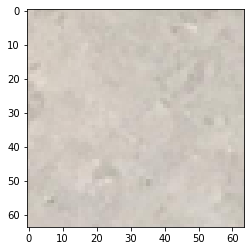

In [4]:
#training 이미지 예시
plt.imshow(x_train[0])

# Build Model

In [5]:
latent_dim = 1024 #latent vector의 크기

encoder_net = tf.keras.Sequential([ #인코더 - 차원 축소
    InputLayer(input_shape=(64, 64, 3)),
    Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu), 
    Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
])

decoder_net = tf.keras.Sequential([ #디코더 - 차원을 다시 늘림
    InputLayer(input_shape=(latent_dim,)),
    Dense(4 * 4 * 128),
    Reshape(target_shape=(4, 4, 128)),
    Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu), 
    Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(32, 4, strides=2, padding='same', activation=tf.nn.relu),
    Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid') #0~1 사이의 값
])

od = OutlierVAE(
    threshold=.005, #instance score (0.005 이상이면 outlier이다.)
    score_type='mse',
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=latent_dim,
)

# Train

In [6]:
#학습
od.fit(
    x_train,
    epochs=20,
    batch_size=100,
    verbose=True
)

160/160 [=] - 92s 569ms/step - loss_ma: -22851.4557


# Reconstruct Training Image

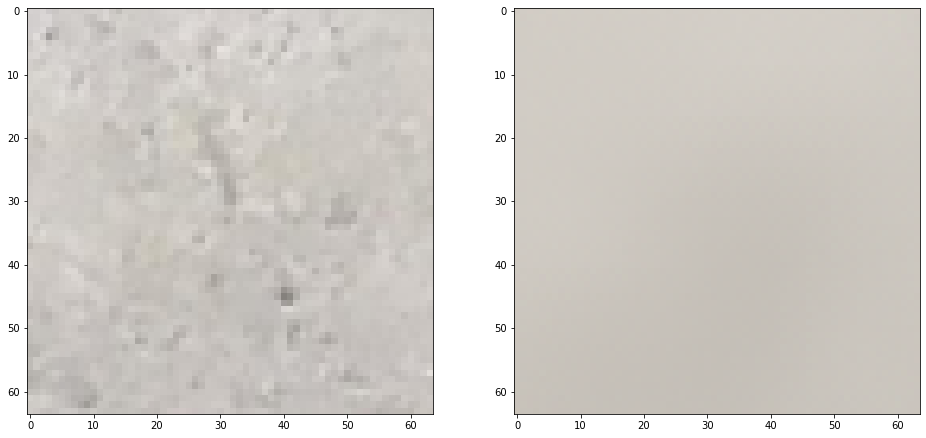

In [7]:
idx = 50 #트레이닝 이미지 중 하나를 골라서 reconstruct
x = x_train[idx].reshape(1, 64, 64, 3)
x_recon = od.vae(x).numpy() 

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(x.squeeze())
axes[1].imshow(x_recon.squeeze())

# Validation

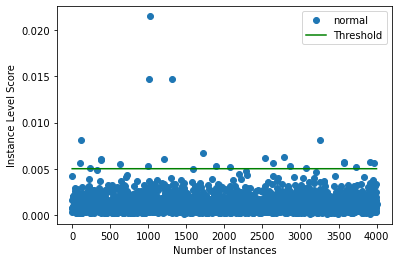

In [134]:
od_valid_preds = od.predict( #alibai detector의 OutlierVAE 내장 메소드 predict()
    x_val,
    outlier_type='instance', 
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_val.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_valid_preds, target, labels, od.threshold) #alibai detector의 plot 그리는 함수
#녹색 선 위로 넘어가면 outlier

# Reconstruct Validation Images

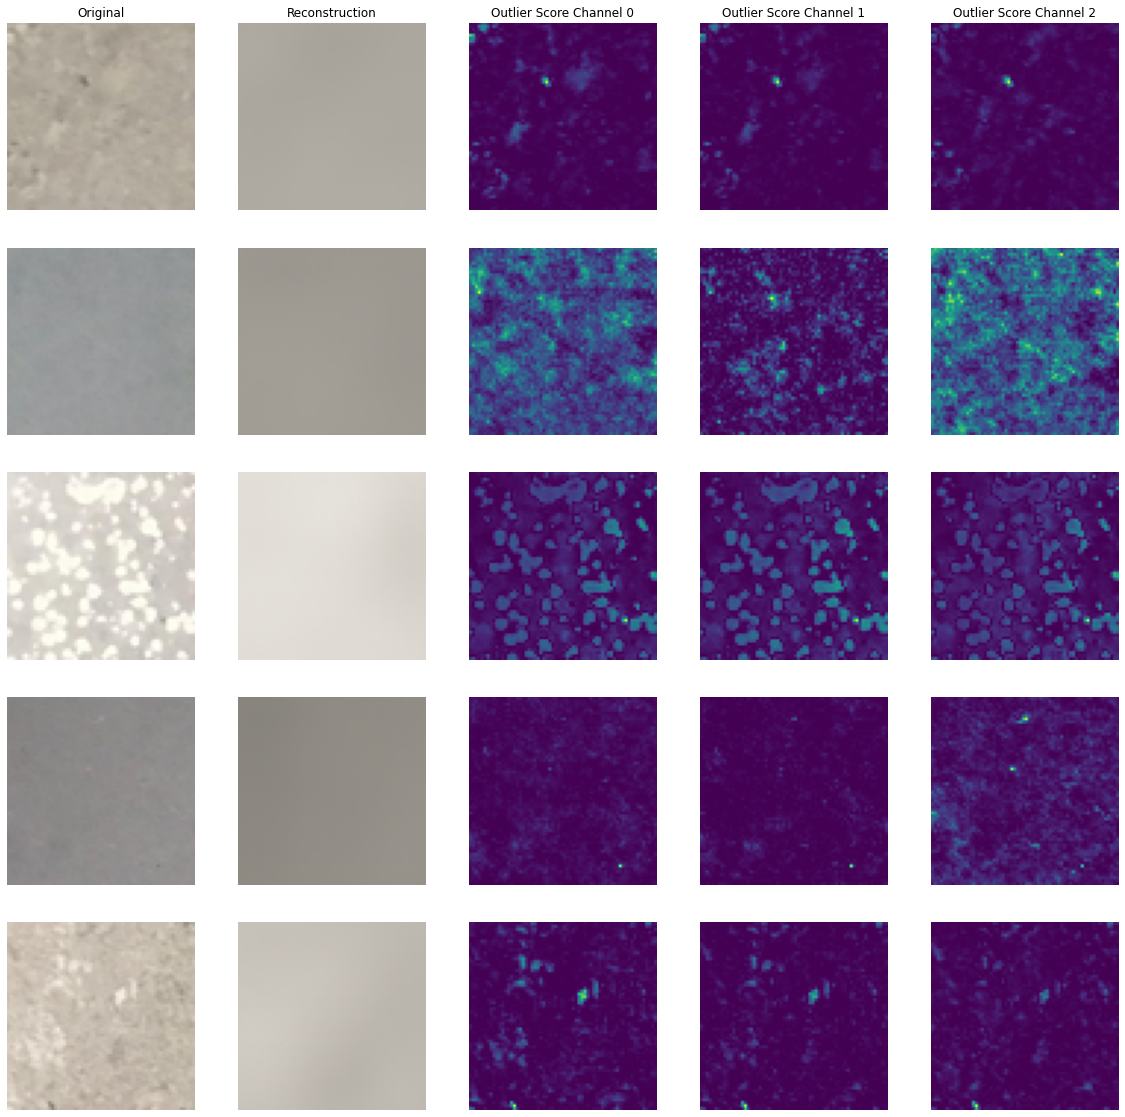

In [135]:
x_valid_recon = od.vae(x_val).numpy()

plot_feature_outlier_image(
    od_valid_preds,
    x_val,
    X_recon=x_valid_recon,
    max_instances=5,
    outliers_only=False 
)

# Outliers

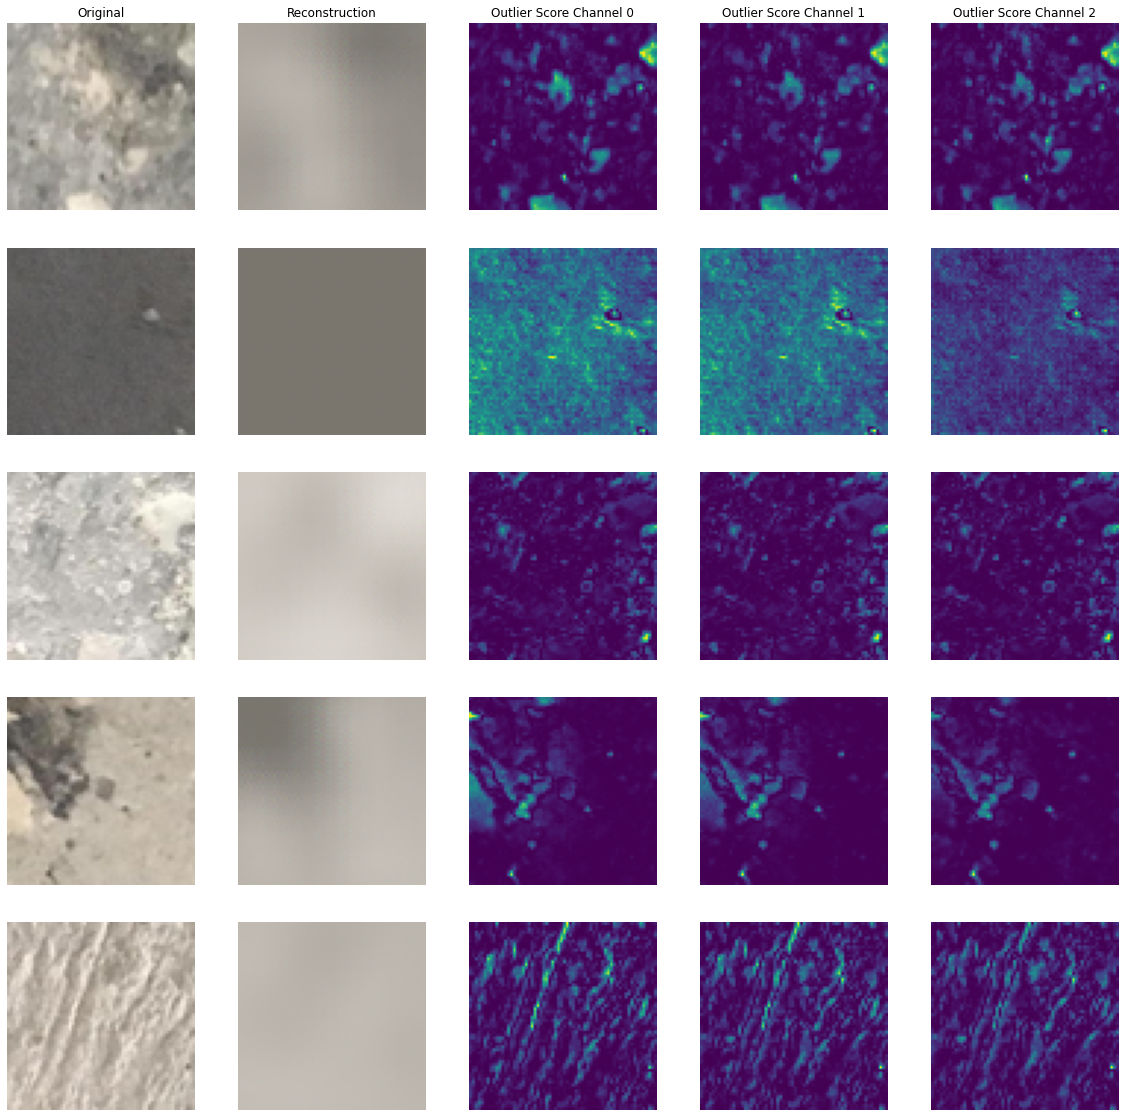

In [136]:
plot_feature_outlier_image(
    od_valid_preds,
    x_val,
    X_recon=x_valid_recon,
    max_instances=5,
    outliers_only=True
) 

# Test with Crack Images

In [12]:
test_img_list = glob('Positive/*.jpg')

x_test = img_to_np(test_img_list[:1000])
x_test = x_test.astype(np.float32) / 255.

print(x_test.shape)

(1000, 64, 64, 3)


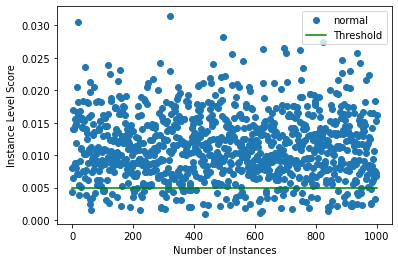

In [137]:
od_test_preds = od.predict(
    x_test,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

target = np.zeros(x_test.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_test_preds, target, labels, od.threshold)

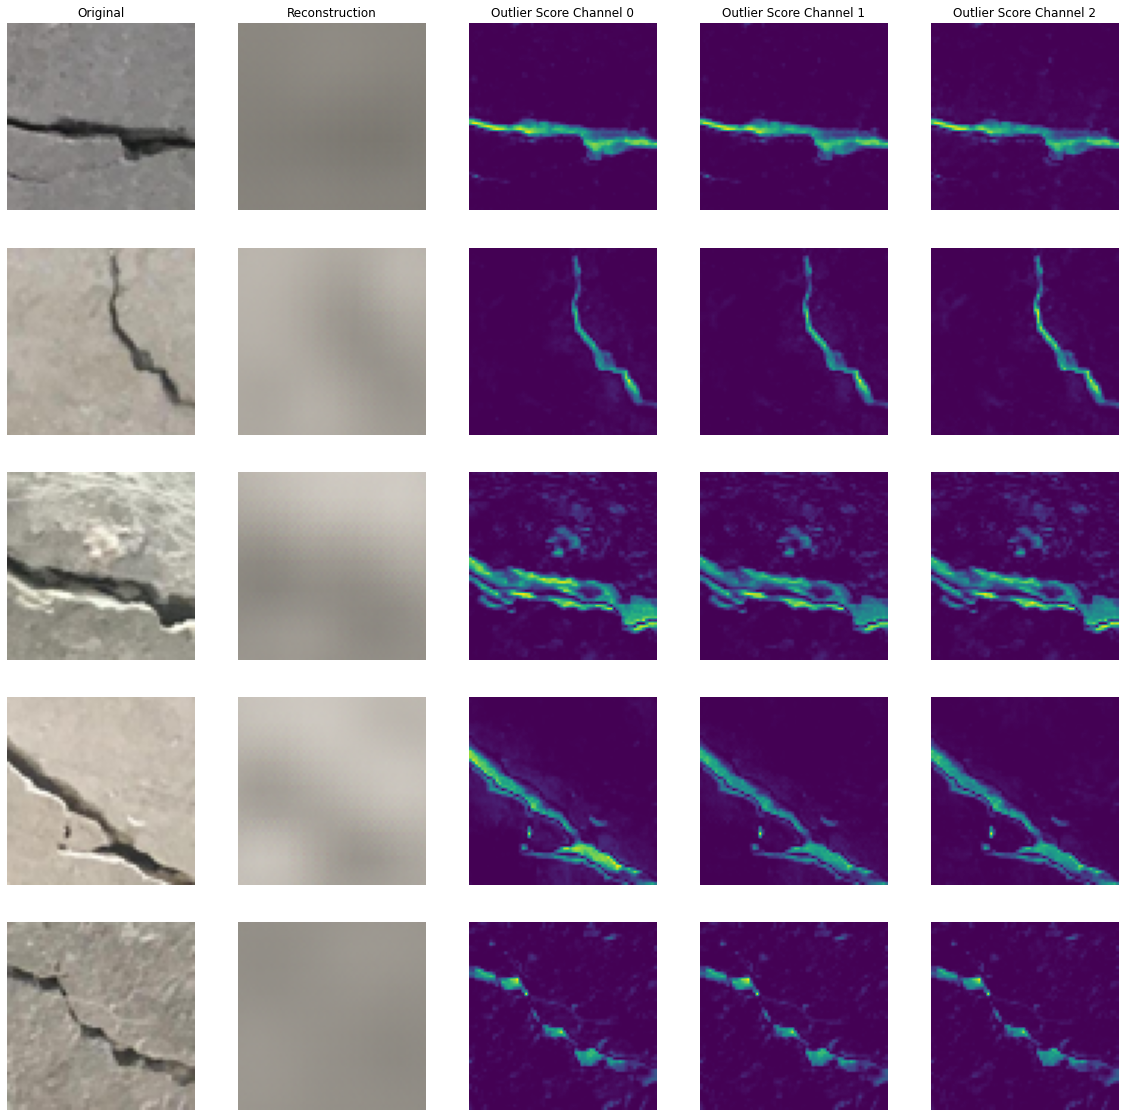

In [138]:
x_test_recon = od.vae(x_test).numpy()

plot_feature_outlier_image(
    od_test_preds,
    x_test,
    X_recon=x_test_recon,
    max_instances=5,
    outliers_only=False
)
#reconstruction 이미지는 모델이 정상 이미지만 학습했기 때문에 깨끗한 이미지로 나옴. original - recontruction 해서 outlier를 체크함.

# Improving

해당 이미지의 Crack이 발생한 영역을 percentage로 나타내는 함수 추가

In [176]:
def show_img_pct(x_test,x_test_recon,idx):
    recon = np.sum(x_test[idx]-x_test_recon[idx], axis=2)
    recon_list = []
    for row in recon:
        for pix in row:
            if pix < -0.1:
                pix = -1
            else: pix=0
            recon_list.append(pix)
    outlier_score = recon_list.count(-1)/len(tmp_list) * 100
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    fig.suptitle('{}th image ({}%)'.format(idx,round(outlier_score,2)),fontsize=17)
    axes[0].imshow(x_test[idx].squeeze())
    axes[0].set_title("Original image")
    axes[1].imshow(x_test_recon[idx].squeeze())
    axes[1].set_title("Reconstructed image")
    fig.tight_layout()
    fig.subplots_adjust(top=1)
    plt.show()

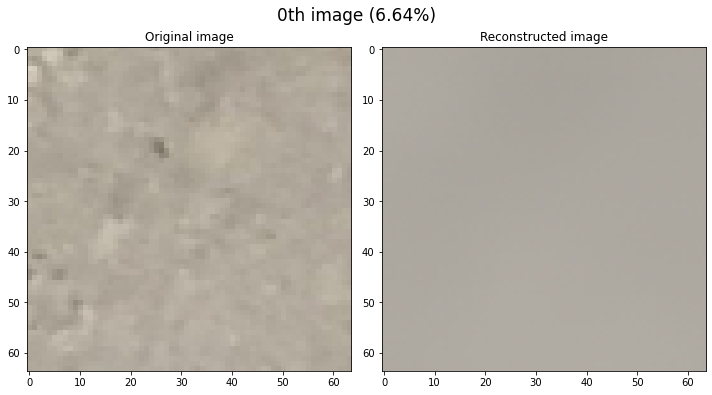

In [177]:
show_img_pct(x_val,x_valid_recon,0)

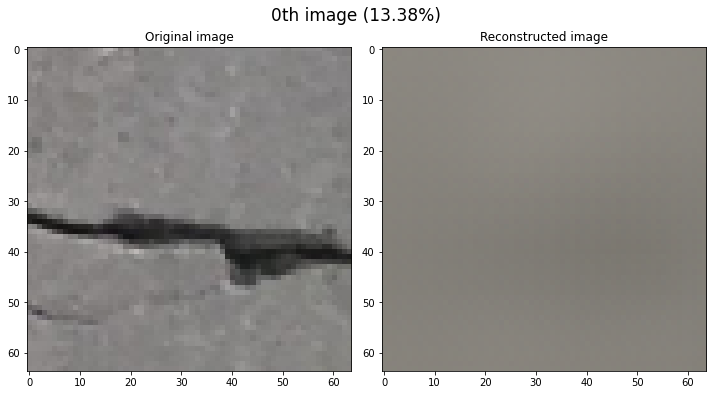

In [178]:
show_img_pct(x_test,x_test_recon,0)

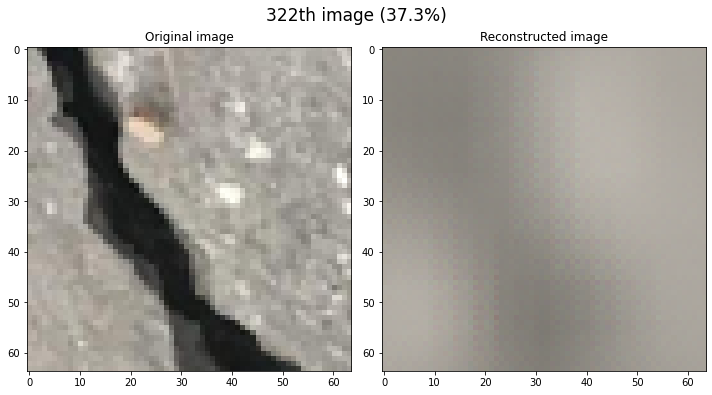

In [179]:
show_img_pct(x_test,x_test_recon,322)

# Test with real image

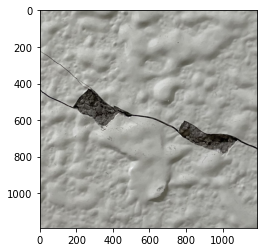

In [142]:
test_image = Image.open('crack_image_sample.jpeg')
plt.imshow(test_image)

In [159]:
test_image = img_to_np(['crack_image_sample.jpeg'])
test_image = test_image.astype(np.float32) / 255.
print(test_image.shape)

(1, 64, 64, 3)


In [160]:
od_preds = od.predict(
    test_image,
    outlier_type='instance',
    return_feature_score=True,
    return_instance_score=True
)

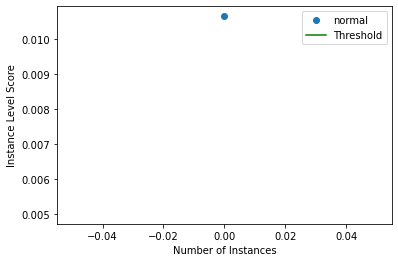

In [161]:
target = np.zeros(test_image.shape[0],).astype(int)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold)

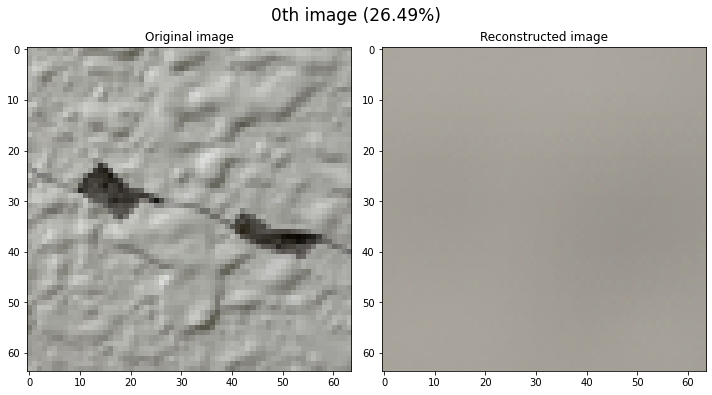

In [180]:
test_image_recon = od.vae(test_image).numpy()
show_img_pct(test_image,test_image_recon,0)